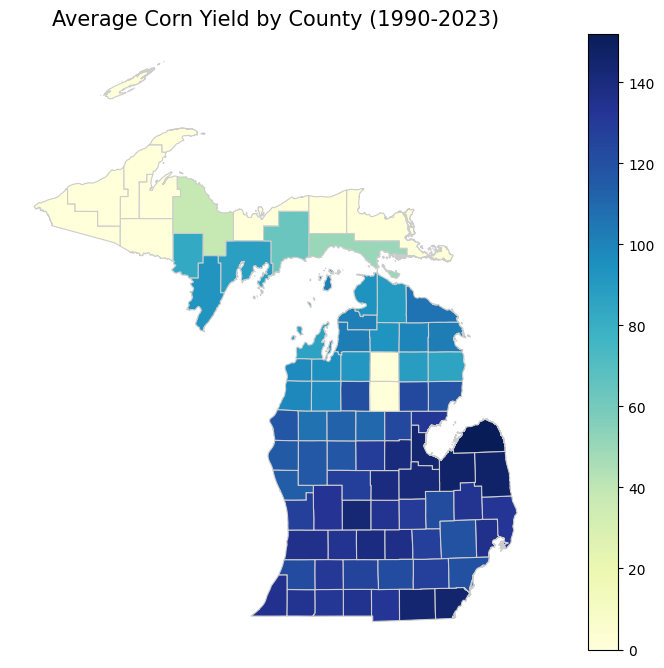

In [33]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the GeoJSON file containing county boundaries
gdf = gpd.read_file('County.geojson')

# Load USDA data from 1950 to 2024 into a single DataFrame
usda_data = pd.concat([pd.read_csv(f'data/usda_data_{year}.csv') for year in range(1990, 2023)])

# Handle missing values in the 'county_ansi' column by dropping rows with NaN values
usda_data = usda_data[usda_data['county_ansi'].notna()]

# Clean the 'Value' field by removing invalid or missing entries, then convert to numeric
usda_data['Value'] = usda_data['Value'].replace({'(D)': np.nan, '(NA)': np.nan})
usda_data.dropna(subset=['Value'], inplace=True)
usda_data['Value'] = pd.to_numeric(usda_data['Value'], errors='coerce')

# Convert 'county_ansi' to integer, then back to string, ensuring proper format
usda_data['county_ansi'] = usda_data['county_ansi'].astype(int).astype(str).str.zfill(3)

# Group the USDA data to calculate the average yield for each county
usda_grouped = usda_data.groupby('county_ansi')['Value'].mean().reset_index()

# Ensure 'FIPSCode' is in string format and properly formatted
gdf['FIPSCode'] = gdf['FIPSCode'].astype(str).str.zfill(3)

# Merge the USDA data with the GeoJSON county boundaries data
merged_gdf = gdf.merge(usda_grouped, left_on='FIPSCode', right_on='county_ansi', how='left')

# Handle missing yield values by filling NaN with 0 for counties without yield data
merged_gdf['Value'] = merged_gdf['Value'].fillna(0)

# Create a choropleth map of average corn yield by county
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged_gdf.plot(column='Value', cmap='YlGnBu', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Add titles and labels to the map
plt.title('Average Corn Yield by County (1990-2023)', fontsize=15)
plt.axis('off')  # Hide axis

# Show the plot
plt.show()

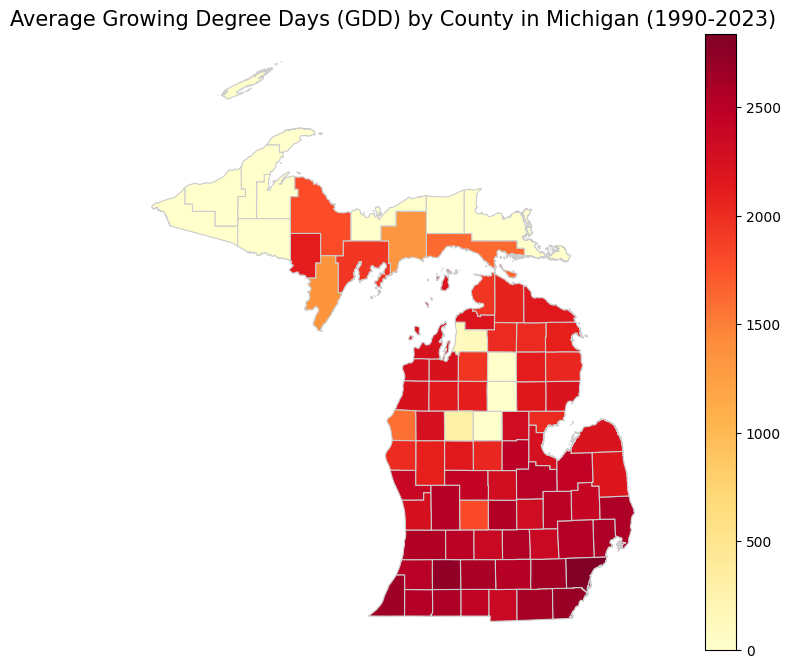

In [34]:
# Load the GeoJSON file containing county boundaries
gdf = gpd.read_file('County.geojson')

# Load weather data from 1950 to 2024 into a single DataFrame
weather_data = pd.concat([pd.read_csv(f'data/weather_data_{year}.csv') for year in range(1990, 2023)])

# Ensure 'date' is in datetime format
weather_data['date'] = pd.to_datetime(weather_data['date'])

# Extract year from 'date'
weather_data['year'] = weather_data['date'].dt.year

# Calculate Growing Degree Days (GDD) for each county using the available weather data
weather_data['TMAX'] = weather_data['TMAX'].clip(lower=50, upper=86)
weather_data['TMIN'] = weather_data['TMIN'].clip(lower=50)
weather_data['TAVG'] = (weather_data['TMAX'] + weather_data['TMIN']) / 2
weather_data['GDD'] = weather_data['TAVG'] - 50

# Group the weather data by county and year, then calculate the mean GDD for each county across all years
gdd_grouped = weather_data.groupby(['county_ansi', 'year'])['GDD'].sum().reset_index()

# Calculate the average GDD for each county across the full date range (1950-2024)
gdd_avg = gdd_grouped.groupby('county_ansi')['GDD'].mean().reset_index()

# Convert 'county_ansi' to string format, ensuring proper format
gdd_avg['county_ansi'] = gdd_avg['county_ansi'].astype(int).astype(str).str.zfill(3)

# Ensure 'FIPSCode' is also formatted as a string for proper merging
gdf['FIPSCode'] = gdf['FIPSCode'].astype(str).str.zfill(3)

# Merge the average GDD data with the GeoJSON county boundaries data
merged_gdf = gdf.merge(gdd_avg, left_on='FIPSCode', right_on='county_ansi', how='left')

# Handle missing GDD values by filling NaN with 0 for counties without GDD data
merged_gdf['GDD'] = merged_gdf['GDD'].fillna(0)

# Create a choropleth map of average GDD by county over the full date range
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged_gdf.plot(column='GDD', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Add titles and labels to the map
plt.title('Average Growing Degree Days (GDD) by County in Michigan (1990-2023)', fontsize=15)
plt.axis('off')  # Hide axis

# Show the plot
plt.show()